# Modify Below

### Note: Running times are not reproducible

In [1]:
neuron_list = [20, 40, 60, 80, 100] # number of recurrent neurons
n_epoch = 5
ntrial = 5

# Import Packages

In [2]:
try:
  import tension
except ImportError:
  !git clone https://github.com/zhenruiliao/tension.git tension
  !pip install -e tension
  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import tensorflow as tf
import time 

In [4]:
from tension.base import FORCEModel
from tension.models import NoFeedbackESN
from tension.callbacks import TimeHistory

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'ticks')

In [6]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
EXTRA_SIZE = 24
 
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRA_SIZE)  # fontsize of the figure title

# JAX Numpy Implementation of FORCE

In [7]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [8]:
def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: number of neurons
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """
  key, skeys = keygen(key, 5)
  hscale = 0.25
  ifactor = 1.0 / jnp.sqrt(u)
  hfactor = g / jnp.sqrt(n)
  pfactor = 1.0 / jnp.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) * hfactor,
          'wO' : random.normal(next(skeys), (m,n)) * pfactor,
          'wF' : random.normal(next(skeys), (n,m)) * ffactor,
          'dt_over_tau' : dt / tau}

def new_force_params(n, alpha=1.0):
  """Generate new 'parameters' for the RLS learning rule.

  This routine essentially initializes the inverse correlation matrix in RLS.

  Arguments:
    n: number of neurons
    alpha: initial learning rate

  Returns: 
    A dictionary with RLS parameters.
  """
  identity_3d = np.zeros((n,n,n))
  idx = np.arange(n)
  identity_3d[:, idx, idx] = 1    

  return {'P' : jnp.eye(n) * alpha, 'P_recurr': jnp.array(identity_3d) * alpha}

def esn(x, a, h, z, wI, wR, wF, wO, dtdivtau):
  """Run the continuous-time Echostate network one step.
  
    da/dt = -a + wI x + wR h + wF z (last part not needed for no feedback ESN)

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of pre-activations from prev time step
      h: ndarray of neuron firing rates from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns: 
      The update to the ESN at this time step.
  """
  dadt = -a + jnp.dot(wI, x) + jnp.dot(wR, h) # + np.dot(wF, z) # feedback removed
  a = a + dtdivtau * dadt
  h = jnp.tanh(a)
  z = jnp.dot(wO, h)
  
  return a, h, z

def rls(h, z, f, wO, P):
  """Perform the recursive least squares step for the output kernel.
  
    Arguments: 
      h: ndarray of neuron firing rates from prev time step
      z: ndarray of output at current time step
      f: ndarray of targets at current time step
      wO: ndarray of output weights, shape (m, n)
      P: ndarray, inverse correlation matrix, shape (n,n)

    Returns: 
      A 4-tuple of the updated wO, updated P, and delta w and P
  """
  k = jnp.expand_dims(jnp.dot(P, h), axis=1)
  hPh = jnp.dot(h.T, k)
  c = 1.0 / (1.0 + hPh)

  dP = jnp.dot(c * k, jnp.dot(jnp.expand_dims(h, axis=0), P))
  P = P - dP

  e = jnp.atleast_2d(z - f)
  dw = jnp.dot(jnp.expand_dims(jnp.dot(P, h), axis=1), e).T

  return wO - dw, P, dw, dP     

def update_recurr_P(h, z, f, P_recurr, wR):
  """Perform the recursive least squares step for the recurrent kernel.
  
    Arguments: 
      h: ndarray of neuron firing rates from prev time step
      z: ndarray of output at current time step
      f: ndarray of targets at current time step
      P_recurr: ndarray, inverse correlation matrix, shape (n,n,n)
      wR: ndarray of recurrent weights, shape (n,n)

    Returns: 
      A 4-tuple of the updated wR, updated P_recurr, and delta wR and P_recurr
  """
  h = jnp.expand_dims(h, axis=1)
  Ph = jnp.dot(P_recurr, h)[:,:,0] # need to multiply by error term to get n x n matrix of weight updates (indiced by i x j)
  hPh = jnp.expand_dims(jnp.dot(Ph, h), axis=2) # n x 1 x 1 array for i
  htP = jnp.dot(jnp.transpose(h),P_recurr)[0] # indiced by i x k, n x n matrix 
  
  dP_recurr = jnp.expand_dims(Ph, axis=2) * jnp.expand_dims(htP, axis=1)  / (1 + hPh) 
  P_recurr -= dP_recurr
  e = jnp.atleast_2d(z - f)
  assert e.shape == (1,1)
  dwR = e * jnp.dot(P_recurr, h)[:,:,0]

  return wR - dwR, P_recurr, dwR, dP_recurr 

In [9]:
def esn_run_and_train_jax(params, fparams, x_t, f_t=None, do_train=False):
  """Run the Echostate network forward a number of steps the length of x_t.
  
    This implementation uses JAX to build the outer time loop from basic
    Python for loop.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  # per-example predictions
  a = params['a0']
  h = jnp.tanh(a)
  wO = params['wO']
  wI = params['wI']
  wR = params['wR']
  wF = params['wF']
  z = jnp.dot(wO, h)
  if do_train:
    P = fparams['P']
    P_recurr = fparams['P_recurr']
  else:
    P = None
    P_recurr = None
  h_t = []
  z_t = []

  dP = 0
  dw = 0
  dtdivtau = params['dt_over_tau']

  for tidx, x in enumerate(x_t):
    a, h, z = esn(x, a, h, z, wI, wR, wF, wO, dtdivtau)

    if do_train:
      wO, P, dw, dP = rls(h, z, f_t[tidx], wO, P)
      wR, P_recurr, dwR, dP_recurr = update_recurr_P(h, z, f_t[tidx], P_recurr, wR)
    h_t.append(h)
    z_t.append(z)
    
  if do_train:
    fparams['P'] = P
    fparams['P_recurr'] = P_recurr
  params['wO'] = wO
  params['wR'] = wR
  params['a0'] = a
  
  h_t = jnp.array(h_t)  
  z_t = jnp.array(z_t)
  return params, fparams, h_t, z_t

def esn_run_jax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays of neuron firing rates and the outputs.
  """
  _, _, h_t, z_t  = esn_run_and_train_jax(params, None, x_t, 
                                          None, do_train=False)
  return h_t, z_t

esn_run_jax_jit = jit(esn_run_jax)

def esn_train_jax(params, fparams, x_t, f_t):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays 
        of neuron firing rates and the outputs.
  """
  return esn_run_and_train_jax(params, fparams, x_t, f_t, do_train=True)
  
esn_train_jax_jit = jit(esn_train_jax)

# Define Sum of Sinusoid Target

In [10]:
def fullforce_oscillation_test(dt, showplots=0):
    dt_per_s = round(1/dt)
    
    # From the paper, and the online demo:
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.zeros((2*dt_per_s+1,1))
    omega = np.linspace(2*np.pi, 6*np.pi, 1*dt_per_s+1)
    targ = np.zeros((2*dt_per_s+1,1))
    targ[0:(1*dt_per_s+1),0] = np.sin(t[0:(1*dt_per_s+1),0]*omega)
    targ[1*dt_per_s:(2*dt_per_s+1)] = -np.flipud(targ[0:(1*dt_per_s+1)])
    
    # A simpler example: just a sine wave
    '''
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*omega)
    '''
    
    # A slightly harder example: sum of sine waves
    
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*2*omega) * np.sin(t*omega/4)
    
    
    inp = np.zeros(targ.shape)
    inp[0:round(0.05*dt_per_s),0] = np.ones((round(0.05*dt_per_s)))
    hints = np.zeros(targ.shape)

    if showplots == 1:
        plt.figure()
        plt.plot(targ)
        plt.plot(hints)
        plt.plot(inp)
        plt.legend(['Target','Hints','Input'])
    
    return inp, targ, hints

# Create Input and Iarget

(401, 1)


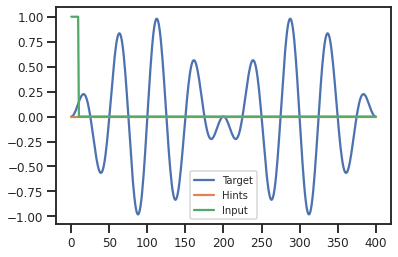

In [11]:
tau = 0.025 * 2
dt =  tau / 10

inp, targ, hints = fullforce_oscillation_test(dt=dt, showplots=1)
targ = targ.astype(np.float32)
inp = inp.astype(np.float32)
assert inp.shape[0] == targ.shape[0]
print(targ.shape)

u = inp.shape[1] # input dimension
alpha = 1e0 # constant for initializing the P matrix
m = targ.shape[1] # output dimension
g = 1.5 # gain parameter that controls the chaos

# Find Running Time of FORCE Trained Network Using JAX Numpy Implementation

In [12]:
%%time 

functional_final_dict = {}
for n in neuron_list:
  time_n_overall = []
  for trial_idx in range(ntrial):
    print('Trial: ', trial_idx)
    params_seed = np.random.randint(0, 10000000)
    print("Params seed %d" %(params_seed))
    key = random.PRNGKey(params_seed)
    init_params = random_esn_params(key, u, n, m, tau=tau, dt=dt, g=g)

    # Copy the params to the ones we will be training.
    params = dict.copy(init_params)
    fparams = new_force_params(n, alpha=alpha)

    mae_history = []
    time_jax = []
    for train_idx in range(n_epoch):
      start = time.time()
      # replace esn_train_jax with esn_train_jax_jit for jit optimization
      params, fparams, h_t, z_t = esn_train_jax(params, fparams, jnp.array(inp), jnp.array(targ)) 
      time_jax.append(time.time() - start)
      mae_history.append(jnp.mean(jnp.abs(z_t - targ)).item())
      print(f'Epoch: {train_idx + 1} Time: {round(time_jax[-1],4)}','MAE: ', round(mae_history[-1], 4))
    time_n_overall.append(time_jax)
  functional_final_dict[n] = np.array(time_n_overall)
  assert functional_final_dict[n].shape == (ntrial, n_epoch)

Trial:  0
Params seed 2270727
Epoch: 1 Time: 19.9898 MAE:  0.2699
Epoch: 2 Time: 3.7929 MAE:  0.3161
Epoch: 3 Time: 3.1572 MAE:  0.3636
Epoch: 4 Time: 2.0243 MAE:  0.3269
Epoch: 5 Time: 2.3714 MAE:  0.3487
Trial:  1
Params seed 1865523
Epoch: 1 Time: 2.1751 MAE:  0.191
Epoch: 2 Time: 2.8877 MAE:  0.3001
Epoch: 3 Time: 1.6461 MAE:  0.3322
Epoch: 4 Time: 2.0744 MAE:  0.3282
Epoch: 5 Time: 1.7784 MAE:  0.2935
Trial:  2
Params seed 9358380
Epoch: 1 Time: 2.3479 MAE:  0.2224
Epoch: 2 Time: 2.1759 MAE:  0.3423
Epoch: 3 Time: 1.5709 MAE:  0.4114
Epoch: 4 Time: 1.6076 MAE:  0.3946
Epoch: 5 Time: 1.5682 MAE:  0.3956
Trial:  3
Params seed 7864184
Epoch: 1 Time: 1.5879 MAE:  0.1547
Epoch: 2 Time: 1.9494 MAE:  0.3317
Epoch: 3 Time: 2.9433 MAE:  0.3524
Epoch: 4 Time: 1.6044 MAE:  0.3335
Epoch: 5 Time: 1.6028 MAE:  0.3399
Trial:  4
Params seed 1019686
Epoch: 1 Time: 2.4147 MAE:  0.2747
Epoch: 2 Time: 2.1933 MAE:  0.3968
Epoch: 3 Time: 3.6643 MAE:  0.335
Epoch: 4 Time: 3.9533 MAE:  0.3981
Epoch: 5 Ti

# Find Running Time FORCE Trained Network using tension


In [13]:
targ_tensor = tf.convert_to_tensor(targ, dtype=tf.float32) 
inp_tensor = tf.convert_to_tensor(inp, dtype=tf.float32)

In [14]:
tension_final_dict = {}
for n in neuron_list:
  time_tension = []
  for trial_idx in range(ntrial):
    print('Trial ', trial_idx)
    time_history = TimeHistory()
    myesn = NoFeedbackESN(dtdivtau=dt/tau, units=n, output_size=m, activation='tanh')
    model = FORCEModel(force_layer=myesn, alpha_P=alpha) 
    model.compile(metrics=["mae"])
    history = model.fit(x=inp_tensor,
                        y=targ_tensor, 
                        epochs=n_epoch, 
                        callbacks=[time_history])
    time_tension.append(time_history.times)
  tension_final_dict[n] = np.array(time_tension)
  assert tension_final_dict[n].shape == (ntrial, n_epoch)

Trial  0
Epoch 1/5
401/401 [==============================] - 2s 2ms/step - mae: 0.2598
Epoch 2/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3224
Epoch 3/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3203
Epoch 4/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3420
Epoch 5/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3068
Trial  1
Epoch 1/5
401/401 [==============================] - 1s 2ms/step - mae: 0.2390
Epoch 2/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3430
Epoch 3/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3399
Epoch 4/5
401/401 [==============================] - 1s 2ms/step - mae: 0.2794
Epoch 5/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3008
Trial  2
Epoch 1/5
401/401 [==============================] - 1s 2ms/step - mae: 0.2483
Epoch 2/5
401/401 [==============================] - 1s 2ms/step - mae: 0.3558
Epoch 3/5
401/401 [======

# Time Comparison Plots

In [15]:
functional_result = []
for key, val in functional_final_dict.items():
  temp = np.mean(val, axis=1)
  functional_result.append([key, np.mean(temp), np.std(temp, ddof=1)])

functional_result = np.array(functional_result)

In [16]:
tension_result = []
for key, val in tension_final_dict.items():
  temp = np.mean(val, axis=1)
  tension_result.append([key, np.mean(temp), np.std(temp, ddof=1)])

tension_result = np.array(tension_result)

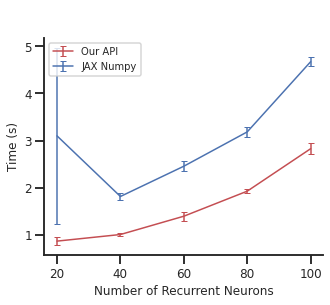

In [17]:
fig, (ax1) = plt.subplots(1, 1, sharey = True, figsize=(5,4))

ax1.errorbar(tension_result[:,0], tension_result[:,1], yerr=tension_result[:,2], label='Our API', color='r', linewidth=1.5, capsize=3)
ax1.errorbar(functional_result[:,0], functional_result[:,1], yerr=functional_result[:,2], label='JAX Numpy', color='b', linewidth=1.5, capsize=3)

ax1.set_xticks(functional_result[:,0])
ax1.set_xlabel('Number of Recurrent Neurons')
ax1.set_ylabel('Time (s)')
ax1.legend(loc='upper left')
ax1.set_title('\n')

sns.despine(ax=ax1)